# Mixed problem: Darcy's flow in porous media
---

Let us consider Poisson's problem in mixed form, in which we have both, the flux variable $\boldsymbol{J}$ and the scalar variable $p$
(the pressure), that satisfy

\begin{equation}
\left \{
\begin{array}{rcll}
\nabla \cdot \boldsymbol{J} & = & f & \mbox{in}~~\Omega \\
& & & \\
\boldsymbol{J} & = & -\boldsymbol{\kappa} \cdot \nabla{p} & \mbox{in}~~\Omega \\
& & & \\
p & = & p_D & \mbox{on}~~\partial{\Omega}_D \\
& & & \\
\boldsymbol{J} \cdot \check{\mathbf{n}} & = & J_N & \mbox{on}~~\partial{\Omega}_N \\
\end{array}
\right.
\end{equation}

where $\boldsymbol{\kappa} \in [L^{\infty}(\Omega)]^{d \times d}$ 
is in general a full tensor. Rewrite the second equation as

$$
\boldsymbol{\kappa}^{-1} \cdot \boldsymbol{J} + \nabla{p} = 0
$$

This leads us to the following variational problem: Find $(\boldsymbol{J}, p) \in V_{J} \times Q$ such that

\begin{eqnarray}
{\int_{\Omega}}{\boldsymbol{\kappa}^{-1} \cdot \boldsymbol{J} \cdot \mathbf{v}}\,dx  - {\int_{\Omega}}{p\,\nabla \cdot \mathbf{v}}\,dx & = &
-{\int_{\partial{\Omega}_D}}{p_D \left (\mathbf{v} \cdot \check{\mathbf{n}}\right )}\,ds \\
{\int_{\Omega}}{q\,\nabla \cdot \boldsymbol{J}}\,dx & = & {\int_{\Omega}}{f\,q}\,dx 
\end{eqnarray}
$\forall (\mathbf{v},q) \in V_0 \times Q.$

Notice that, in contrast to the primal formulation of Poisson's problem we have been dealing until now, in the mixed form, the Neumann condition $J$ on $\Gamma_N$ appears (**strongly**) as a restriction on the trial set $V_{J}$ for $\boldsymbol{J}$ and the Dirichlet condition
$p_D$ on $\Gamma_D$ appears (**naturally**) in the variational problem.

In abstract form we write: Find $(\mathbf{u}, p) \in V_{J} \times Q$ such that

\begin{equation}
\left.
\begin{array}{rlll}
a(\mathbf{u},\mathbf{v}) - b(\mathbf{v},p) & = & \ell(\mathbf{v}) \\
b(\mathbf{u},q) & = & g(q) 
\end{array}
\right.
\end{equation}
$\forall (\mathbf{v},q) \in V_0 \times Q$.

In [ ]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

!wget "https://raw.githubusercontent.com/IgorBaratta/FEniCSxCourse/main/Problem6_Darcy/perm_field.dat"

In [ ]:
from dolfinx import mesh, fem, io, plot

from ufl import SpatialCoordinate, FiniteElement, MixedElement, TestFunction, TrialFunction, split, Measure, dx, ds, grad, div, dot, inner, as_vector, FacetNormal

import gmsh
import numpy as np
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

## Finite element mesh

First, create the finite element mesh, we can use triangular or quadrilateral elements, just by uncommenting the appropriate flag below

* `mesh.CellType.triangle`
* `mesh.CellType.quadrilateral`

We also may select a structured mesh using the convinience
`dolfinx` function `mesh.create_rectangle` or a more general partitions
or the `gmsh` library as usual:

In [ ]:
# Computational mesh 
Lx, Ly = 11.0/3.0, 1.0
#cell_type = mesh.CellType.triangle
cell_type = mesh.CellType.quadrilateral

simple_mesh = False

if(simple_mesh):
  msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                              points=((0.0, 0.0), (Lx, Ly)), n=(220, 60),
                              cell_type=cell_type)
else:
  def GenerateMesh():
    gmsh.initialize()
    proc = MPI.COMM_WORLD.rank

    if proc == 0:
        # We create one rectangle and the circular inclusion
        background = gmsh.model.occ.addRectangle(0, 0, 0, Lx, Ly)
        gmsh.model.occ.synchronize()
        pl = gmsh.model.addPhysicalGroup(2, [background], 1)

    gmsh.model.mesh.setSize(gmsh.model.getEntities(0), 0.04)

    if(cell_type == mesh.CellType.quadrilateral):
      gmsh.model.mesh.setRecombine(2, pl)
    
    gmsh.model.mesh.generate(2)    
    
    msh, subdomains, boundaries = io.gmshio.model_to_mesh(gmsh.model, comm=MPI.COMM_WORLD, rank=0, gdim=2)
    gmsh.finalize()
    return msh, subdomains, boundaries

  msh, subdomains, boundaries = GenerateMesh()

# Visualize the mesh
with io.XDMFFile(MPI.COMM_WORLD, "mymesh.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)

# Identify the four boundaries
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], Lx)),
              (3, lambda x: np.isclose(x[1], 0)),
              (4, lambda x: np.isclose(x[1], Ly))]

facet_indices, facet_markers = [], []
fdim = msh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(msh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(msh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = Measure("ds", domain=msh, subdomain_data=facet_tag)

if(False):
  one = fem.Constant(msh, 1.0)
  for i in [1, 2, 3, 4]:
    length_form = fem.form( one*ds(i) )
    lengthside = fem.assemble_scalar(length_form)
    print(lengthside)

##  Highly heterogeneous coefficient

In this tutorial we will see how to load some data to define the permeability field. In this case we consider the isotropic
case, i.e.,

$$
\boldsymbol{\kappa}(\mathbf{x}) = \kappa(\mathbf{x})\,\mathbf{I}_{d\times d}
$$

We will solve the famous **SPE10** benchmark
used in reservoir engineering. We load the data contained in file `perm_field.dat` as follows

In [ ]:
if(cell_type == mesh.CellType.triangle):
    el_kappa = FiniteElement("DG",  msh.ufl_cell(), 0)
else:
    el_kappa = FiniteElement("DQ",  msh.ufl_cell(), 0)

K = fem.FunctionSpace(msh, el_kappa)
kappax = fem.Function(K)
invkappax = fem.Function(K)

# Physical size of global domain SPE10
Lx, Ly = 11.0/3.0, 1.0
Nx, Ny = 220, 60
Dx, Dy = Lx/Nx, Ly/Ny
      
# Read the data 
table = open('perm_field.dat', 'r')
lista = table.readlines()
table.close()
      
kx_array = np.zeros(shape=(Nx,Ny))
for i in range(Nx):
  for j in range(Ny):
    k = Nx*j + i
    kx_array[i,j] = float(lista[k].split()[0])

Notice how the field is highly heterogeneous

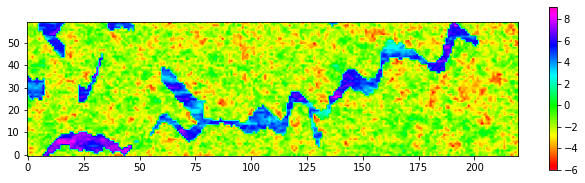

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(33/3, 3))
plt.imshow(np.log(kx_array[:,:].T), origin="leftbottom", cmap='gist_rainbow')
plt.colorbar()
plt.show()

Now, we must assign this values to a function belonging to an appropriate 
finite element space. To that end we will use as in other ocassions an elementwise constant function. Notice that for triangular and quadrilateral cells we must properly declare the corresponding element type:

* `DG` for triangular elements 
* `DQ` for quadrilateral elements

and finally interpolate the data to the function representing the permeability ${\kappa}$, which can be efficiently done in the following way:

In [ ]:
def EvalKappa(x):
  icellf = 0.99999999*x[0]/Dx
  jcellf = 0.99999999*x[1]/Dy
  icell = icellf.astype(int)
  jcell = jcellf.astype(int)
  return kx_array[icell,jcell]

kappax.interpolate(EvalKappa)

# Visualize in Paraview
kappax.name = "kappa"
with io.XDMFFile(msh.comm, "kappa.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(kappax)

from google.colab import files
files.download('kappa.xdmf') 
files.download('kappa.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Mixed variational formulation

We first notice that alternatively, the problem can be written by defining a unique bilinear and linear form by substracting the two equations:

Find $(\mathbf{u},p) \in V_{J} \times Q$ such that
\begin{equation}
\underbrace{{a}(\mathbf{u},\mathbf{v}) - b(\mathbf{v},p) - b(\mathbf{u},q)}_{B\left ((\mathbf{u},p), (\mathbf{v},q) \right ) } =  \underbrace{\ell(\mathbf{v}) - g(q)}_{L \left ((\mathbf{v},q)\right )}
\end{equation}
$\forall (\mathbf{v},q) \in V_0 \times Q$,

so the problem is defined in the product space $W_J = V_{J} \times Q$ as

Find $(\mathbf{u},p) \in W$ such that 
\begin{equation}
B\left ((\mathbf{u},p), (\mathbf{v},q) \right ) = L \left ((\mathbf{v},q)\right )~~~\forall (\mathbf{v},q) \in W_0 
\end{equation}

and this is how we are actually defining the variational problem in 
`dolfinx`.

Now, the proper functional setting for this problem is, for 
the velocity space:

$$
V = H(\mbox{div},\Omega) = 
\{\mathbf{v} \in [L^2(\Omega)]^d,~~\nabla \cdot \mathbf{v} \in L^2(\Omega)  \}
$$

$$
V_J = \{\mathbf{v} \in V,~~\mathbf{v}\cdot \check{\mathbf{n}} = J~\mbox{on}~\partial{\Omega}_N \}
$$

and the pressure space:

$$
Q = L^2(\Omega)
$$

Popular discrete subspaces are the Raviart-Thomas (`RT` or `RTCF`) and Brezzi-Douglas-Marini (`BDM` or `BDMCF`) spaces wich are available in `dolfinx`, such that we ensure the velocity has continuous normal
component. These are used in combination with
spaces of discontinuous functions for the pressure field, so as to end 
up with a stable formulation:

In [ ]:
degree_u = 1
degree_p = 0

if(cell_type == mesh.CellType.triangle):
    el_u = FiniteElement("RT", msh.ufl_cell(), degree_u)
    el_p = FiniteElement("DG",  msh.ufl_cell(), degree_p)
else:
    el_u = FiniteElement("RTCF", msh.ufl_cell(), degree_u)
    el_p = FiniteElement("DQ",  msh.ufl_cell(), degree_p)

# Define the mixed element 
el_m  = MixedElement([el_u , el_p])
# and the corresponding global space
W = fem.FunctionSpace(msh, el_m)

Recalling, the bilinear and linear forms are:

$$
B((\mathbf{u},\mathbf{v}), (p,q)) = 
\int_{\Omega}{\kappa}^{-1} \boldsymbol{J} \cdot \mathbf{v}\,dx -
{\int_{\Omega}}{p\,\nabla \cdot \mathbf{v}}\,dx
- 
{\int_{\Omega}}{q\,\nabla \cdot \mathbf{u}}\,dx
$$

$$
L((\mathbf{v}, q)) = {\int_{\partial{\Omega}_D}}{p_D \left (\mathbf{v} \cdot \check{\mathbf{n}} \right )}\,ds
- {\int_{\Omega}}{f\,q}\,dx 
$$


In [ ]:
TrialF = TrialFunction(W)
TestF = TestFunction(W)
(u, p) = split(TrialF)
(v, q) = split(TestF)

# Source term
f = fem.Constant(msh, 0.0)

pleft  = fem.Constant(msh, 100.0)
pright = fem.Constant(msh, 0.0)

# Define variational form
n = FacetNormal(msh)
B = ((1.0/kappax)*inner(u, v) - div(v)*p - div(u)*q) * dx
L = f * q * dx - pleft*dot(v,n)*ds(1) - pright*dot(v,n)*ds(2)

and finally, the **essential** boundary conditions (this take some work):

In [ ]:
# Define some function, such that g.n = J (the flux data)
def g(x, n):
  return (np.zeros_like(x[0]), np.zeros_like(x[0]))

W0, U_to_W = W.sub(0).collapse()
w_bc = fem.Function(W0)

sdim = msh.topology.dim
top_facets = mesh.locate_entities_boundary(msh, sdim-1, lambda x: np.isclose(x[1], Ly))
top_cells = mesh.compute_incident_entities(msh, top_facets, sdim-1, sdim)
w_bc.interpolate(lambda x: g(x, (0,1)), top_cells)

bottom_facets = mesh.locate_entities_boundary(msh, sdim-1, lambda x: np.isclose(x[1], 0))
bottom_cells = mesh.compute_incident_entities(msh, bottom_facets, sdim-1, sdim)
w_bc.interpolate(lambda x: g(x, (0,1)), bottom_cells)

w_bc.x.scatter_forward()

bc_dofs = fem.locate_dofs_topological((W.sub(0), W0), sdim-1, np.hstack([top_facets, bottom_facets]))
bcs = [fem.dirichletbc(w_bc, bc_dofs, W.sub(0))]

The discrete algebraic problem that emanates from this variational formulation has
the typical **saddle point** structure, i.e.,

$$
\begin{bmatrix}
A & B \\
B^{\intercal} & 0
\end{bmatrix} 
\begin{bmatrix}
\mathsf{U} \\
\mathsf{P}
\end{bmatrix} 
= 
\begin{bmatrix}
\mathsf{F} \\
\mathsf{G}
\end{bmatrix} 
$$

where $\mathsf{X} = [\mathsf{U}, \mathsf{P}]^{\intercal}$
is the global vector of velocity and pressure unknowns.
Solving this problem by means of iterative methods, which is mandatory
for large systems, generally in the 3D case, can be quite challenging,
requiring efficient **preconditioners**. In our 2D case we can solve using direct methods:

In [ ]:
wh = fem.Function(W)
petsc_opts={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "superlu", "ksp_monitor": None}
problem = fem.petsc.LinearProblem(B, L, bcs=bcs, u=wh, petsc_options=petsc_opts)
problem.solve()
(uh,ph) = wh.split()

# Verification
inflow = fem.assemble_scalar(fem.form(dot(uh,n)*ds(1)))
outflow = fem.assemble_scalar(fem.form(dot(uh,n)*ds(2)))
bottomflow = fem.assemble_scalar(fem.form(dot(uh,n)*ds(3)))
topflow = fem.assemble_scalar(fem.form(dot(uh,n)*ds(4)))
print("\nInflow =%f\nOutflow=%f\nTopflow=%f\nBotflow=%f" %(inflow, outflow, topflow, bottomflow))

  Residual norms for dolfinx_solve_139964446781392 solve.
  0 KSP Residual norm 5.099019513593e+02 
  1 KSP Residual norm 7.262543146341e-12 

Inflow =-6.470282
Outflow=6.470282
Topflow=0.000000
Botflow=0.000000


Since in this case the source term $f = 0$, the inflow must be equal to the outflow, a fact that the discrete formulation is able to capture.
To visualize the velocity field in `Paraview`, we must first interpolate onto a space of vector functions, e.g., a `DG` space:

In [ ]:
if(cell_type == mesh.CellType.triangle):
    BDM_out = fem.VectorFunctionSpace(msh, ("DG", 1))
else:
    BDM_out = fem.VectorFunctionSpace(msh, ("DQ", 1))
u_out = fem.Function(BDM_out)
u_out.interpolate(uh)
u_out.name = "Velocity"
with io.XDMFFile(msh.comm, "vel.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(u_out)

ph.name = "Pressure"
with io.XDMFFile(msh.comm, "pres.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(ph)

from google.colab import files
files.download('vel.xdmf')
files.download('vel.h5')
files.download('pres.xdmf')
files.download('pres.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Homework 6

Solve the same problem using the primal formulation
we have seen in our first lecture and compare the results.
Compute the mass balance and observe how it fails as compared to
the mixed formulation.

In [ ]:
def SolvePoissonPrimal(msh):
  
  V = fem.FunctionSpace(msh, ("CG", 1))

  nunks = V.dofmap.index_map.size_global
      
  dofsL = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
  dofsR = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], Lx))
  bcs = [fem.dirichletbc(ScalarType(100.0), dofsL, V), fem.dirichletbc(ScalarType(0.0), dofsR, V)]

  p, q = TrialFunction(V), TestFunction(V)
  
  #kappax = fem.Constant(msh, 1.0)
  a = inner(kappax*grad(p), grad(q)) * dx
  f = 0.0
  source = fem.Constant(msh, f)
  L = source * q * dx
  problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
  ph = problem.solve()

  ds = Measure("ds", domain=msh, subdomain_data=facet_tag)

  Jh = -kappax*grad(ph)
  n = FacetNormal(msh)
  inflow = fem.assemble_scalar(fem.form(dot(Jh,n)*ds(1)))
  outflow = fem.assemble_scalar(fem.form(dot(Jh,n)*ds(2)))
  bottomflow = fem.assemble_scalar(fem.form(dot(Jh,n)*ds(3)))
  topflow = fem.assemble_scalar(fem.form(dot(Jh,n)*ds(4)))
  print("\nInflow =%f\nOutflow=%f\nTopflow=%f\nBotflow=%f" %(inflow, outflow, topflow, bottomflow))

  return ph

phprimal = SolvePoissonPrimal(msh)

phprimal.name = "Pressure"
with io.XDMFFile(msh.comm, "presprimal.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(phprimal)


Inflow =-10.764238
Outflow=10.664222
Topflow=-0.587108
Botflow=0.140792
